<a href="https://www.kaggle.com/code/davidphummel/computer-vision-is-it-a-dog-or-a-cat?scriptVersionId=197169494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Computer Vision - Is it a dog or a cat?

## Introduction

This is the first Juypter notebook I created while reading chapter 1 of the Fastai course called [Practical Deep Learning](https://course.fast.ai).  Practical Deep Learning is a free course designed for people who have some coding experience and want to learn how to apply deep learning and maching learning to practical problems.  

I believe an understanding of how to program in Python is a requirement to complete this course along the ability to learn mathematical concepts like gradient descent.  

I have spent some time refershing my memory of the NumPy package using the book [NumPy for Data Analysis](https://wesmckinney.com/book/numpy-basics) by Wes McKinney.  The NumPy package is used in the course to load and clean data along with building the models.  

I have also found the need to refresh my memory of some of mathmatical concepts used in deep learning including gradient descent.  I really recommend the videos produced by [StatQuest](https://statquest.org/) on [gradient descent](https://youtu.be/sDv4f4s2SB8?si=SZjknb9ca-nl18ie) and others related to statistics and machine learning.  Josh Starmer created StatQuest to attempt to explain statistics to his former co-wokers.  His vidoes are short, easy to understand, and engaging! 

This Juypter notebook is a copy of Jeremy Howard's notebook called [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data).  I modified Jeremy's notebook to train a model to determine if an image is a dog or a cat.  My family has two portuguese water dogs and 1 three legged cat, so I thought it would be fun to test the model on them.

The basic steps we'll take are:

1. Use DuckDuckGo to find images of dogs and cats on the Internet.
2. Fine-tune a pretrained neural network to recognise these two animals.
3. Run the model on my family pets to determine if it can accuratley identify each animal.

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqqq fastai fastbook

## Step 1: Download images of dogs and cats

Let's start out by defining a function to search the Internet using DuckDuckGo for a *term* (e.g., "dog") which returns a set of URLs to images of the *term*.

Note:  Fastcore is a libruary that adds features to Python inspired by other languages like multiple dispatch from Julia, mixins from Ruby, and currying, binding, and more from Haskell. It also adds some “missing features” and clean up some rough edges in the Python standard library, such as simplifying parallel processing, and bringing ideas from NumPy over to Python’s list type.

In [3]:
from fastcore.all import *
from fastbook import search_images_ddg
from fastdownload import download_url

# search_images will search for a term on the Internet and return a set of URLs which contain the term
def search_images(term, max=30):
  print(f"Searching for '{term}' using DuckDuckGo")
  return search_images_ddg(term, max_images=max)

Let's search for and download a set of dog and cat images off the Internet.  We are grabbing a set of images in both categories with different lighting.  The dog images will be stored in "animals/dog" and the cat images will be stored in "animals/cat".  These images will be used to create the  model training and validation datasets.

In [4]:
from time import sleep
from fastdownload import download_url
from fastai.vision.all import *

terms = 'dog','cat'
path = Path('animals')

for term in terms:
    dest = (path/term)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{term} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{term} sun photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{term} shade photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/term, max_size=400, dest=path/term)

Searching for 'dog photo' using DuckDuckGo
Searching for 'dog sun photo' using DuckDuckGo
Searching for 'dog shade photo' using DuckDuckGo


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'cat photo' using DuckDuckGo
Searching for 'cat sun photo' using DuckDuckGo
Searching for 'cat shade photo' using DuckDuckGo


## Step 2: Train the model

Since some of the download images might not download correctly (which could cause our model training to fail), we will remove them.

In [5]:
# Find the images that can't be opened
failed = verify_images(get_image_files(path))

# Remove the image files which can't be openend.  The map function will execute the
# Path.unlink function over the failed images in the failed (L) object.
failed.map(Path.unlink)

print(f"{len(failed)} images were removed because they could not be verified.")

9 images were removed because they could not be verified.


To train a model, we will use `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it.

Here what each of the `DataBlock` parameters means:

- ***blocks=(ImageBlock, CategoryBlock)*** - The input to our model are images and the outputs are catogries (in this case either a dog or a cat)

- ***get_items=get_image_files*** - To find all the inputs to the model we run the 'get_image_files' function which results a list of all the image files in the path.

- ***splitter=RandomSplitter(valid_pct=0.2, seed=42)*** - Spilt the data into training and validation sets randomly using 20% of the adta for the valication set.

- ***get_y=parent_label*** - The labels (i.e., 'y' value) is the name of the 'parent' of each file (i.e., the name of the folder each file is located in which will be either *dog* or *cat*).  

- ***item_tfms=[Resize(192, method='squish')]*** - Resize each image to 192x192 pixles by "squishing" (vs. cropping) before training.

We will display a batch of the images which will be used to train the model.  One of the challenges with approach of downloading images from the Internet is we might download a image which do not accurately reflect a dog or a cat but is catorized as such.  These images should be identified and removed from the training and validation datasets to improve the accuracy of the model.  Fastai recommends training your model first, then using the results to clean-up the dataset, and finally retraining the model using the updated dataset.  I will not perform these activities in this notebook.

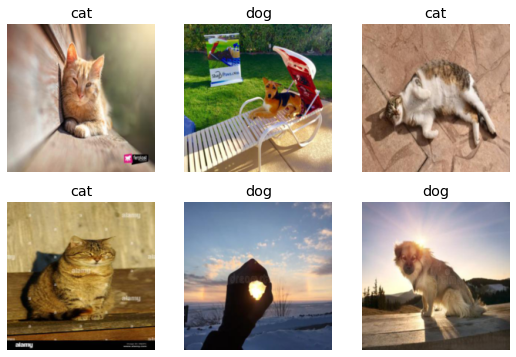

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train the model using the`resnet18` pre-trained model. ResNet-18 is a convolutional neural network that is 18 layers deep. 

We can train this model in a few minutes using a CPU. However, I recommend using a GPU due to its speed in processing cycles.  `fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories.

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.157307,0.546733,0.187500,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.308090,0.414539,0.156250,00:02
1,0.223595,0.436462,0.125000,00:01
2,0.148830,0.451278,0.125000,00:01
3,0.114991,0.457639,0.125000,00:01


Let's display the confusion matrix which shows the disparty between the correct and incorrect predictions made by the model for each image in the validation dataset.  Let's also display the images with the top losses along with their prediction, actual, loss, and proabilty of the actual category.

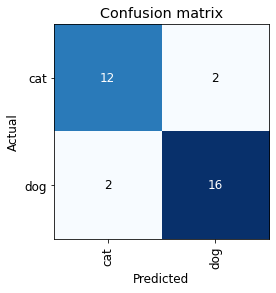

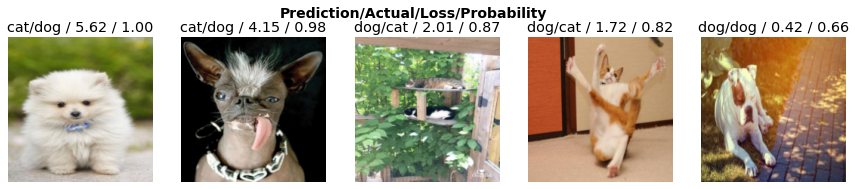

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5,nrows=1)

## Step 3: Use the model

Let's use the model to predict the type of animal, a dog or cat, for each of my family pets.  The results of this model will vary depending on the accuracy of the training and validation datasets.  At times, the model will have a hard time determiming Lucy is a dog and Chica is a cat.

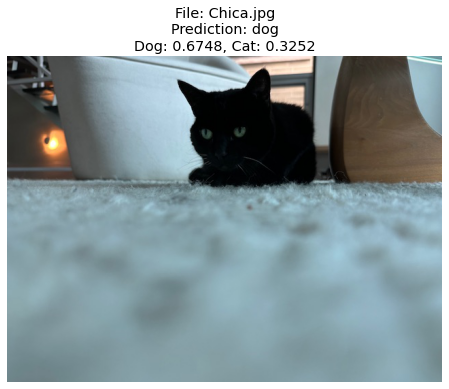

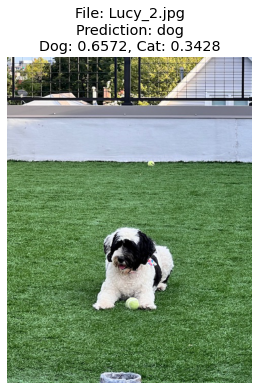

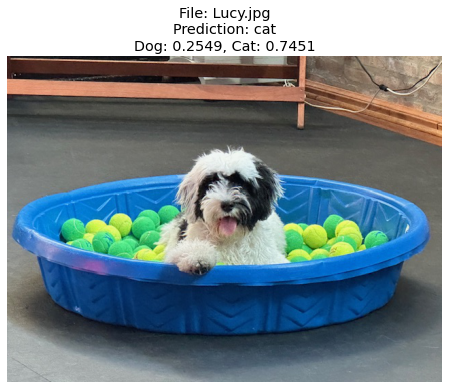

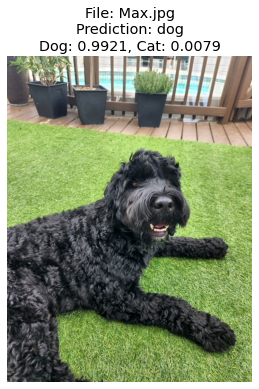

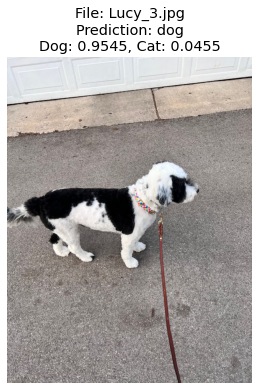

In [9]:
from fastai.vision.all import *
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Function to test a image and display the results
def test_image(img_path):
    img = Image.open(img_path)
    img = ImageOps.exif_transpose(img)
    pred, pred_idx, probs = learn.predict(img)
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"File: {img_path.name}\nPrediction: {pred}\nDog: {probs[1]:.4f}, Cat: {probs[0]:.4f}")
    plt.show()

# Test the model using the pets in the My Famliy Pets dataset 
my_family_pets_path = Path("../input/my-family-pets")
for img_path in get_image_files(my_family_pets_path):
    test_image(img_path)